In [1]:
"""
Short module to simulate the MFCS unit in room g015 at the university of applied sciences in mannheim. First, values are simulated that are based on a true historical yeast experiment. Then a noise is added to the simulated values and at the end the data is uploaded as the MFCS unit in g015 would do.

"""
from biomoni.Experiment import Experiment
from biomoni.Yeast import Yeast
from biomoni.visualize import visualize

from settings import Simulation_path, exp_id, units_id, variables_id, values_id, url, sample_interval
import numpy as np
from scipy import integrate
from opcua import Server
import time
from datetime import datetime
from param_collection import p0
%load_ext autoreload
%autoreload 2


In [2]:
##Simulate an Experiment by using the metadata from an real Experiment - F7 in thise case
path = Simulation_path
Exp = Experiment(path, exp_id)  #load experiment 7
y = Yeast()
hours = 8
t_grid = np.linspace(0,hours, hours*60)     #measuring times * 60 means 1 timepoint each minute
y.set_params(p0) #set params to params in settings#simulate with experimental data, params from settings_mimic and selected number of steps
sim = y.simulate(Exp, t_grid = t_grid)     #507 steps for 8.45 hours in exp 7 means 1 step per minute
sim["BASET"] = integrate.cumtrapz(sim["BASET_rate"], x= sim.index, initial = 0) #integrate base rate to get cumulative base signal



##add random noise array to simulated data 
noise = np.random.normal(0, 0.01, np.shape(sim)) # noise with expected value:0 STDDEV:0.01, same shape as simulated data
sim = sim * (1+ noise)

visualize(sim)

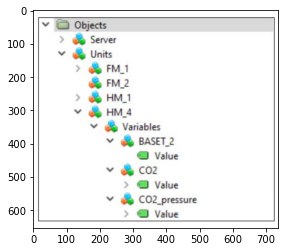

In [3]:
#Create an object of the class Server
server = Server()
#Set up the Host name and the port number at which the server will be running

url = url
server.set_endpoint(url)

#Create a namespace of the server. It takes the name as an argument
#AdressSpace is the place where all the set of objects and related information are stored
addspace=server.register_namespace("MFCS_Server_mimic")

#create objects
objects = server.get_objects_node()     #returns a node object
Units =objects.add_object('ns=2;s="Units"', "Units")    #Units correspond to the four bioreactors: Herr Menta and Frau Menta each control unit controls two bioreactors

FM_1= Units.add_object(*units_id["FM_1"])
FM_2= Units.add_object(*units_id["FM_2"])
HM_3= Units.add_object(*units_id["HM_3"])
HM_4= Units.add_object(*units_id["HM_4"])

#add variables category object to just Herr Menta 4
Variables = HM_4.add_object('ns=2;s="Variables"', "Variables")

#add different variable objects to Variables category
BASET = Variables.add_object(*variables_id["BASET"])
CO2 = Variables.add_object(*variables_id["CO2"])
CO2_p = Variables.add_object(*variables_id["CO2_pressure"])
PDatTime = Variables.add_object(*variables_id["ts"])


#add values to the variables
Value_BASET = BASET.add_variable(*values_id["BASET"])        #default value is zero: gets changed anyway
Value_CO2 = CO2.add_variable(*values_id["CO2"])
Value_CO2_p = CO2_p.add_variable(*values_id["CO2_pressure"])
Value_PDatTime = PDatTime.add_variable(*values_id["ts"])


# This is how the server is build up 
# Show structure of MFCS Server
import matplotlib.image as image
import matplotlib.pyplot as plt

img = image.imread('MFCS_scheme.png')
plt.imshow(img)



In [4]:
try:
    print("Start Server")
    server.start()

    i = 0
    while True:
        
        if i > len(sim) -1:
            print("Process finished, last index reached")
            break
        ts = datetime.now().strftime("%d.%m.%Y  %H:%M:%S")     #date time now as string with specified format corresponding to PDatTime format in MFCS

        Value_BASET.set_value(sim["BASET"].iloc[i])
        Value_CO2.set_value(sim["CO2"].iloc[i])
        Value_PDatTime.set_value(ts)

        #just in case you want to make CO2 also random
        Value_CO2_p.set_value(1.058)
        noise_pressure = np.random.normal(0, 0.03)
        Value_CO2_p.set_value(Value_CO2_p.get_value()  * (1+ noise_pressure))
        
        print(Value_PDatTime.get_value(), Value_BASET.get_value(), Value_CO2.get_value(),  Value_CO2_p.get_value())
        
        i += 1
        time.sleep(sample_interval)


finally:
    server.stop()
    print("Server offline")

Endpoints other than open requested but private key and certificate are not set.
Listening on 127.0.0.1:4848


Start Server
22.12.2021  14:36:52 0.0 1.2800973297074492 1.062297399360672
22.12.2021  14:37:52 0.006598196499120496 1.276665859723515 1.061977085728629
22.12.2021  14:38:52 0.01325792568901071 1.2775929593388051 1.0145603120248
22.12.2021  14:39:52 0.019856851694915665 1.2768142682458832 1.0943235203134238
22.12.2021  14:40:52 0.02664066926514252 1.2969238903226146 1.0715631904924612
22.12.2021  14:41:52 0.03390421591194696 1.3112602607396446 1.056401638793598
22.12.2021  14:42:52 0.04114587171944603 1.2968286725771654 0.9843452351903592
22.12.2021  14:43:52 0.04773154330869405 1.2957463019608502 1.0682684104285476
22.12.2021  14:44:52 0.05289602096476606 1.3059151560951057 1.0881219484612128
22.12.2021  14:45:52 0.06054536635020822 1.3297822910860073 1.055588805059108
22.12.2021  14:46:52 0.06751066315209053 1.3116964782000065 1.0588442474017938
22.12.2021  14:47:52 0.0749258340924374 1.3036442359141671 1.0250600701646015
22.12.2021  14:48:52 0.08208332619140589 1.2950919779772476 1.